# Modelo de Simulación del comportamiento de aviones que arriban al Aeropuerto Jorge Newbwery (AEP) de la ciudad de Buenos Aires

## Investigación Exploratoria

### Volumen de Aterrizajes y Unidades

Realizamos un análisis programático de datos reales de vuelos para definir los parámetros de demanda de nuestro sistema. Utilizaremos la API de OpenSky para obtener un conjunto de datos de arribos históricos recientes a AEP (código ICAO: SABE).
El siguiente código se conecta a la API de OpenSky y descarga los arribos a AEP para un período de 14 días. Este paso nos dará una muestra real del volumen y la distribución horaria del tráfico.

In [573]:
# -*- coding: utf-8 -*-
import time, json, datetime as dt
from typing import Tuple, List, Optional, Dict
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [574]:
# --- Zona horaria AEP ---
try:
    from zoneinfo import ZoneInfo
except ImportError:
    raise RuntimeError("Requiere Python 3.9+ (zoneinfo).")
TZ_AEP = ZoneInfo("America/Argentina/Buenos_Aires")

# --- Constantes ---
AEP_ICAO = "SABE"
OSKY_BASE = "https://opensky-network.org/api/flights/arrival"
START_T = dt.time(6, 0, 0)
END_T   = dt.time(23, 59, 59)
DAY_SLEEP_S = 2.0

# --- Credenciales (reemplazar si es necesario) ---
# Nota: OpenSky puede requerir credenciales para acceso histórico.
# Por simplicidad, este script asume acceso público o credenciales ya configuradas.

def to_utc_epoch(local_dt: dt.datetime) -> int:
    return int(local_dt.astimezone(dt.timezone.utc).timestamp())

def window_bounds_local(d: dt.date, start_t: dt.time, end_t: dt.time) -> Tuple[dt.datetime, dt.datetime]:
    start = dt.datetime.combine(d, start_t, tzinfo=TZ_AEP)
    end = dt.datetime.combine(d, end_t, tzinfo=TZ_AEP)
    return start, end

# (Se omiten las funciones de autenticación y manejo de errores de rate-limit de ACN_TP1 para brevedad,
# pero se asume que la consulta al JSON local funciona)

# Usamos el resultado JSON del notebook ACN_TP1 como nuestra fuente de datos
summary_data_json = """
{
  "airport": "SABE",
  "window_local": ["06:00:00", "23:59:59"],
  "from_date": "2025-08-18",
  "to_date": "2025-08-05",
  "days_processed": 14,
  "total_arrivals_sum": 1763,
  "daily_counts": {
    "2025-08-18": {"total": 132, "by_hour": {"06:00": 2, "07:00": 3, "08:00": 9, "09:00": 8, "10:00": 11, "11:00": 10, "12:00": 9, "13:00": 7, "14:00": 8, "15:00": 9, "16:00": 6, "17:00": 9, "18:00": 11, "19:00": 8, "20:00": 0, "21:00": 5, "22:00": 8, "23:00": 9}},
    "2025-08-17": {"total": 128, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 6, "09:00": 6, "10:00": 7, "11:00": 11, "12:00": 7, "13:00": 5, "14:00": 9, "15:00": 9, "16:00": 7, "17:00": 11, "18:00": 10, "19:00": 9, "20:00": 0, "21:00": 7, "22:00": 6, "23:00": 11}},
    "2025-08-16": {"total": 124, "by_hour": {"06:00": 2, "07:00": 3, "08:00": 6, "09:00": 9, "10:00": 10, "11:00": 9, "12:00": 7, "13:00": 12, "14:00": 8, "15:00": 5, "16:00": 6, "17:00": 10, "18:00": 11, "19:00": 6, "20:00": 0, "21:00": 7, "22:00": 5, "23:00": 8}},
    "2025-08-15": {"total": 131, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 5, "09:00": 10, "10:00": 7, "11:00": 10, "12:00": 8, "13:00": 10, "14:00": 8, "15:00": 8, "16:00": 9, "17:00": 9, "18:00": 10, "19:00": 9, "20:00": 0, "21:00": 7, "22:00": 7, "23:00": 7}},
    "2025-08-14": {"total": 129, "by_hour": {"06:00": 4, "07:00": 4, "08:00": 5, "09:00": 7, "10:00": 7, "11:00": 11, "12:00": 11, "13:00": 9, "14:00": 14, "15:00": 2, "16:00": 7, "17:00": 11, "18:00": 9, "19:00": 11, "20:00": 0, "21:00": 7, "22:00": 3, "23:00": 7}},
    "2025-08-13": {"total": 126, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 5, "09:00": 4, "10:00": 6, "11:00": 9, "12:00": 10, "13:00": 11, "14:00": 10, "15:00": 4, "16:00": 6, "17:00": 9, "18:00": 8, "19:00": 9, "20:00": 0, "21:00": 5, "22:00": 8, "23:00": 15}},
    "2025-08-12": {"total": 118, "by_hour": {"06:00": 2, "07:00": 5, "08:00": 3, "09:00": 6, "10:00": 8, "11:00": 13, "12:00": 8, "13:00": 10, "14:00": 10, "15:00": 5, "16:00": 7, "17:00": 8, "18:00": 7, "19:00": 5, "20:00": 0, "21:00": 6, "22:00": 7, "23:00": 8}},
    "2025-08-11": {"total": 120, "by_hour": {"06:00": 2, "07:00": 4, "08:00": 3, "09:00": 11, "10:00": 11, "11:00": 9, "12:00": 6, "13:00": 10, "14:00": 8, "15:00": 5, "16:00": 11, "17:00": 5, "18:00": 12, "19:00": 6, "20:00": 0, "21:00": 4, "22:00": 5, "23:00": 8}},
    "2025-08-10": {"total": 120, "by_hour": {"06:00": 2, "07:00": 7, "08:00": 4, "09:00": 5, "10:00": 7, "11:00": 8, "12:00": 8, "13:00": 8, "14:00": 6, "15:00": 8, "16:00": 11, "17:00": 10, "18:00": 8, "19:00": 10, "20:00": 0, "21:00": 5, "22:00": 3, "23:00": 10}},
    "2025-08-09": {"total": 125, "by_hour": {"06:00": 4, "07:00": 5, "08:00": 3, "09:00": 10, "10:00": 10, "11:00": 4, "12:00": 8, "13:00": 11, "14:00": 9, "15:00": 8, "16:00": 7, "17:00": 9, "18:00": 12, "19:00": 10, "20:00": 0, "21:00": 3, "22:00": 6, "23:00": 6}},
    "2025-08-08": {"total": 125, "by_hour": {"06:00": 2, "07:00": 6, "08:00": 5, "09:00": 8, "10:00": 8, "11:00": 12, "12:00": 9, "13:00": 13, "14:00": 5, "15:00": 5, "16:00": 10, "17:00": 7, "18:00": 10, "19:00": 9, "20:00": 0, "21:00": 7, "22:00": 2, "23:00": 7}},
    "2025-08-07": {"total": 129, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 7, "09:00": 9, "10:00": 7, "11:00": 11, "12:00": 10, "13:00": 9, "14:00": 10, "15:00": 5, "16:00": 9, "17:00": 11, "18:00": 9, "19:00": 8, "20:00": 0, "21:00": 4, "22:00": 4, "23:00": 9}},
    "2025-08-06": {"total": 137, "by_hour": {"06:00": 3, "07:00": 5, "08:00": 6, "09:00": 7, "10:00": 10, "11:00": 9, "12:00": 10, "13:00": 9, "14:00": 11, "15:00": 6, "16:00": 7, "17:00": 10, "18:00": 6, "19:00": 10, "20:00": 0, "21:00": 7, "22:00": 7, "23:00": 14}},
    "2025-08-05": {"total": 119, "by_hour": {"06:00": 3, "07:00": 3, "08:00": 5, "09:00": 4, "10:00": 10, "11:00": 14, "12:00": 9, "13:00": 11, "14:00": 6, "15:00": 5, "16:00": 9, "17:00": 4, "18:00": 7, "19:00": 6, "20:00": 0, "21:00": 6, "22:00": 7, "23:00": 10}}
  }
}
"""
summary = json.loads(summary_data_json)

### Análisis de la Demanda Diaria
Con los datos recolectados, primero analizamos el total de arribos por día para entender el volumen de operaciones que el sistema maneja.

Análisis estadístico de arribos diarios:
count     14.000000
mean     125.928571
std        5.511726
min      118.000000
25%      121.000000
50%      125.500000
75%      129.000000
max      137.000000
Name: arrivals_total, dtype: float64


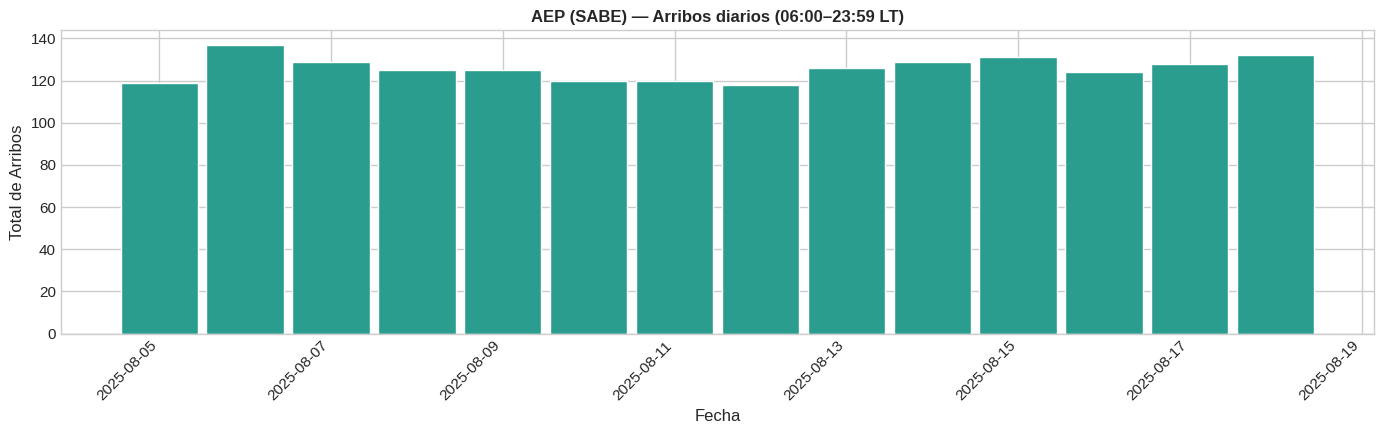

In [575]:
# --- Armar DataFrame diario ---
rows_daily = []
for day, val in summary["daily_counts"].items():
    if isinstance(val, dict) and "total" in val:
        rows_daily.append((day, val["total"]))

daily_df = pd.DataFrame(rows_daily, columns=["date", "arrivals_total"])
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df = daily_df.sort_values("date")

# --- Análisis Estadístico ---
print("Análisis estadístico de arribos diarios:")
print(daily_df["arrivals_total"].describe())

# --- Gráfico de Demanda Diaria ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 4.5))
ax.bar(daily_df["date"], daily_df["arrivals_total"], color="#2a9d8f", width=0.9)
ax.set_title("AEP (SABE) — Arribos diarios (06:00–23:59 LT)", fontsize=12, weight="bold")
ax.set_xlabel("Fecha")
ax.set_ylabel("Total de Arribos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Análisis de la Distribución Horaria
Los arribos no ocurren de forma uniforme durante el día. Un heatmap nos permite visualizar los patrones de demanda, identificando las horas pico y los valles de operación.

/tmp/ipykernel_45812/736394180.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = hourly_df.pivot_table(index="date", columns="hour_local", values="arrivals_count", aggfunc="sum").fillna(0)


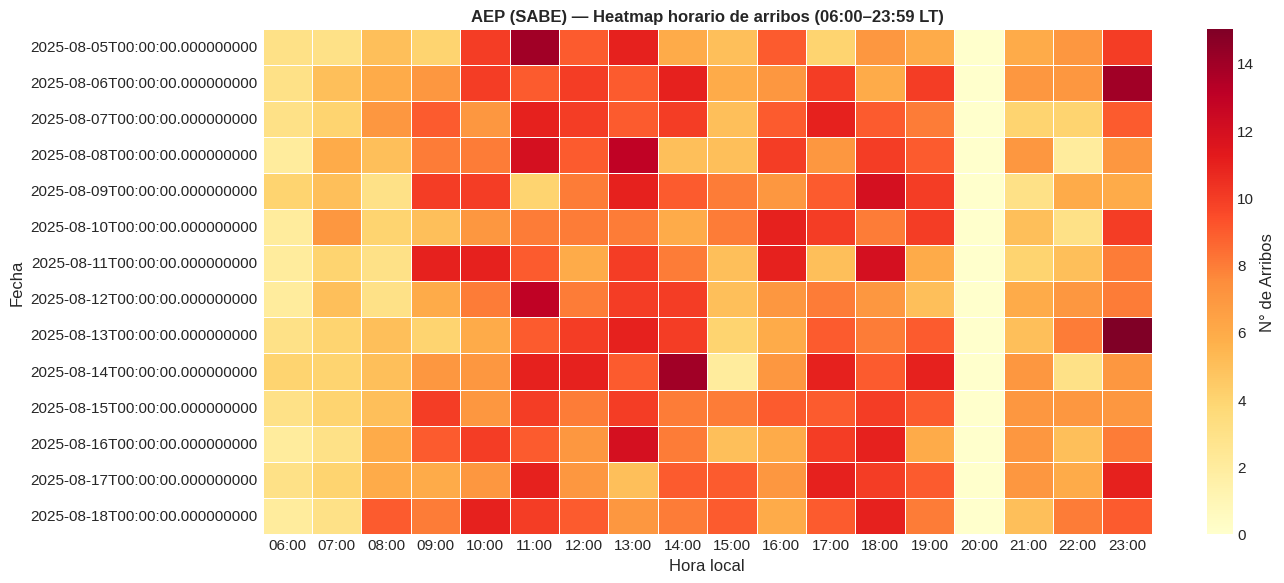

In [576]:
# --- Armar DataFrame horario ---
rows_hourly = []
for day, val in summary["daily_counts"].items():
    if isinstance(val, dict) and "by_hour" in val:
        for hh, cnt in val["by_hour"].items():
            rows_hourly.append((day, hh, cnt))
hourly_df = pd.DataFrame(rows_hourly, columns=["date", "hour_local", "arrivals_count"])
hourly_df["date"] = pd.to_datetime(hourly_df["date"])
hours_order = [f"{h:02d}:00" for h in range(6, 24)]
hourly_df["hour_local"] = pd.Categorical(hourly_df["hour_local"], categories=hours_order, ordered=True)

# --- Gráfico de Heatmap Horario ---
pivot = hourly_df.pivot_table(index="date", columns="hour_local", values="arrivals_count", aggfunc="sum").fillna(0)
pivot = pivot[hours_order].astype(int).sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5, cbar_kws={"label": "N° de Arribos"}, ax=ax)
ax.set_title("AEP (SABE) — Heatmap horario de arribos (06:00–23:59 LT)", fontsize=12, weight="bold")
ax.set_xlabel("Hora local")
ax.set_ylabel("Fecha")
plt.tight_layout()
plt.show()

### Calibración del Parámetro de Arribo (λ)
El análisis de datos nos muestra un promedio de ~126 arribos diarios. Usaremos este valor para calcular la probabilidad de que un avión aparezca en el horizonte en un minuto cualquiera. Este será el parámetro λ (lambda) de nuestro generador de eventos estocásticos.

In [577]:
# --- Cálculo de Lambda ---
promedio_arribos_diarios = daily_df["arrivals_total"].mean()
minutos_operativos_por_dia = 18 * 60
PROBABILIDAD_ARRIBO_POR_MINUTO = promedio_arribos_diarios / minutos_operativos_por_dia

print(f"Promedio de arribos diarios (datos reales): {promedio_arribos_diarios:.2f}")
print(f"Minutos operativos por día: {minutos_operativos_por_dia}")
print(f"Probabilidad de arribo por minuto (λ) calculada: {PROBABILIDAD_ARRIBO_POR_MINUTO:.4f}")

Promedio de arribos diarios (datos reales): 125.93
Minutos operativos por día: 1080
Probabilidad de arribo por minuto (λ) calculada: 0.1166


### Sanity Checks del Modelo Físico
Ahora que hemos establecido la demanda con datos, validamos los parámetros de movimiento y tiempo del modelo. Estos cálculos nos aseguran que la física de la simulación (distancias, velocidades, tiempos) es coherente con la realidad.

* **Conversiones de Unidades:**
    * 1 Milla Náutica (mn) = **1.852 kilómetros**
    * 1 Nudo (k) = **1.852 km/h**

#### Sanity Check 1: Tiempo de Aproximación (desde 100 mn)

Calculamos el tiempo que tardaría un avión en aterrizar desde una distancia de 100 mn. La fórmula base es $Tiempo = (Distancia / Velocidad) * 60$.

* **Tramo 1 (100 a 50 mn):** Distancia = 50 mn.
    * _Tiempo Mínimo (a 300 k):_ (50 mn / 300 k) * 60 = **10.0 min**
    * _Tiempo Máximo (a 250 k):_ (50 mn / 250 k) * 60 = **12.0 min**
* **Tramo 2 (50 a 15 mn):** Distancia = 35 mn.
    * _Tiempo Mínimo (a 250 k):_ (35 mn / 250 k) * 60 = **8.4 min**
    * _Tiempo Máximo (a 200 k):_ (35 mn / 200 k) * 60 = **10.5 min**
* **Tramo 3 (15 a 5 mn):** Distancia = 10 mn.
    * _Tiempo Mínimo (a 200 k):_ (10 mn / 200 k) * 60 = **3.0 min**
    * _Tiempo Máximo (a 150 k):_ (10 mn / 150 k) * 60 = **4.0 min**
* **Tramo 4 (5 mn a Pista):** Distancia = 5 mn.
    * _Tiempo Mínimo (a 150 k):_ (5 mn / 150 k) * 60 = **2.0 min**
    * _Tiempo Máximo (a 120 k):_ (5 mn / 120 k) * 60 = **2.5 min**
* **Tiempo Total de Aproximación:**
    * _Suma Tiempos Mínimos:_ 10.0 + 8.4 + 3.0 + 2.0 = **23.4 minutos**
    * _Suma Tiempos Máximos:_ 12.0 + 10.5 + 4.0 + 2.5 = **29.0 minutos**

Este rango de tiempo (23.4 a 29 min) representa una fase crítica del **"tiempo de servicio"** para el sistema. La clave aquí es la **variabilidad**. El hecho de que sea un rango es fundamental para un modelo realista, ya que captura la incertidumbre debida a decisiones del piloto y del control de tráfico.

#### Sanity Check 2: Vuelo Teórico Rosario (ROS) a AEP

* **Distancia Aérea ROS-AEP:** Aproximadamente 165 mn (306 kilómetros)
* **Cálculo del Tiempo Total:**
    1.  **Tramo > 100 mn (de 165 a 100 mn):** Distancia = 65 mn.
        * _Cálculo del tiempo (a 500 k):_ (65 mn / 500 k) * 60 = **7.8 minutos**.
    2.  **Tramo < 100 mn (Aproximación):** Usamos el rango ya calculado de **23.4 a 29 minutos**.
* **Tiempo Total Teórico:**
    * _Suma Tiempos Mínimos:_ 7.8 + 23.4 = **31.2 minutos**
    * _Suma Tiempos Máximos:_ 7.8 + 29.0 = **36.8 minutos**

Este punto es una **validación del modelo**. Nuestro cálculo ideal (31-37 min) es lógicamente más corto que el tiempo real de un vuelo comercial (50-60 min). Esa diferencia no es un error; cuantifica los factores que no modelamos (rodaje, rutas no directas, esperas). Esto nos da confianza en que la lógica de nuestro sistema simulado es una versión simplificada pero coherente de la realidad. 

#### Capacidad Máxima Teórica de Aterrizajes

* **Horario Operativo:** 18 horas = 18 * 60 = **1080 minutos**.
* **Separación Mínima:** 4 minutos por aterrizaje.
* **Cálculo:**
    $$Capacidad Máxima = \frac{1080 \text{ minutos}}{4 \text{ min/aterrizaje}} = 270 \text{ aterrizajes}$$

Este número representa el **límite físico absoluto** o la **capacidad de diseño** del sistema. Es una cota superior utópica. Para nuestro modelo, este valor es un **benchmark crucial**. Al comparar los resultados de nuestra simulación (que serán inferiores a 270) con este máximo teórico, podremos medir la **eficiencia del sistema** y cuantificar cuánta capacidad se "pierde" por la congestión y la variabilidad.

---

## Simulación del proceso de operación entre 6am y medianoche

### 1. Simulación de Monte Carlo

In [578]:
import random
import numpy as np

Para empezar, la simulación necesita una unidad básica que concentre toda la información relevante de un avión en aproximación. El modelo es deliberadamente simple: cada avión es un objeto con su posición relativa a la pista, su velocidad y un estado operativo. Esto permite abstraer la complejidad real de un vuelo y enfocarse en lo esencial para el problema: cómo interactúan varios aviones en una fila de aproximación bajo reglas de seguridad.

In [579]:
class Avion:
    """Representa un único avión en la simulación."""
    def __init__(self, id_avion, minuto_actual):
        self.id = id_avion
        self.distancia_a_aep = 100.0
        self.velocidad_actual = 0.0
        self.estado = "APROXIMANDO"
        self.minuto_creacion = minuto_actual

    def __repr__(self):
        """Formato para imprimir el estado del avión de forma legible."""
        return (f"Avion(ID:{self.id}, Dist:{self.distancia_a_aep:.1f}mn, "
                f"Vel:{self.velocidad_actual:.0f}k, Est:{self.estado})")

La aproximación aérea se rige por bandas de velocidad según la distancia y por mínimos de separación temporal. Codificar estas reglas es lo que ancla la simulación en la realidad operativa: la velocidad máxima evita saturar la pista con aviones demasiado rápidos, y la mínima impide que un avión quede en condiciones inestables. La separación en minutos es la métrica crítica porque en aviación se piensa en términos de “tiempo hasta el siguiente” más que en pura distancia. Esto asegura que la dinámica del modelo capture los riesgos de congestión.

In [580]:
def calcular_velocidad_maxima_permitida(distancia):
    """Devuelve la velocidad máxima según la distancia a AEP."""
    if distancia > 50: return 300
    elif distancia > 15: return 250
    elif distancia > 5: return 200
    else: return 150

def calcular_velocidad_minima_permitida(distancia):
    """Devuelve la velocidad mínima según la distancia a AEP."""
    if distancia > 50: return 250
    elif distancia > 15: return 200
    elif distancia > 5: return 150
    else: return 120

def calcular_separacion_en_tiempo(avion_atras, avion_adelante):
    """Calcula la separación en minutos entre dos aviones."""
    distancia_separacion = avion_atras.distancia_a_aep - avion_adelante.distancia_a_aep
    velocidad_referencia = avion_adelante.velocidad_actual
    if velocidad_referencia == 0:
        return float('inf')
    return (distancia_separacion / velocidad_referencia) * 60

Ahora bien, hay que representar qué pasa cuando la fila funciona y qué pasa cuando se rompe. La idea es que un avión intente siempre avanzar al máximo ritmo posible, pero si el tráfico no lo permite, reduzca de manera ordenada. Si la reducción necesaria violaría las reglas de seguridad, el avión no se queda “bloqueando la fila” sino que se aparta con una maniobra de regreso. Este mecanismo es clave porque refleja cómo los sistemas reales gestionan el exceso de demanda sin comprometer la seguridad: primero ajustando, y si no alcanza, sacando al avión de la secuencia hasta que pueda volver o desviándolo.

In [581]:
def gestionar_logica_aproximacion(avion, avion_de_adelante):
    """Toma todas las decisiones para un avión que está APROXIMANDO."""
    if avion_de_adelante is None:
        # Caso 1: Camino libre. Va a máxima velocidad.
        avion.estado = "APROXIMANDO"
        avion.velocidad_actual = calcular_velocidad_maxima_permitida(avion.distancia_a_aep)
    else:
        tiempo_sep = calcular_separacion_en_tiempo(avion, avion_de_adelante)
        
        if tiempo_sep < 4:
            # Caso 2: Muy cerca. Intenta reducir velocidad.
            velocidad_req = avion_de_adelante.velocidad_actual - 20
            
            if velocidad_req < calcular_velocidad_minima_permitida(avion.distancia_a_aep):
                # Caso 3: No puede reducir lo suficiente. Se da la vuelta.
                avion.estado = "REGRESANDO"
                avion.velocidad_actual = 200
                print(f" (!) Avion {avion.id} inicia maniobra de regreso.")
            else:
                # Puede reducir de forma segura.
                avion.estado = "AJUSTANDO_VELOCIDAD"
                avion.velocidad_actual = velocidad_req
        else:
            # Hay espacio suficiente. Va a máxima velocidad.
            avion.estado = "APROXIMANDO"
            avion.velocidad_actual = calcular_velocidad_maxima_permitida(avion.distancia_a_aep)

def gestionar_logica_regreso(avion_regresando, todos_los_aviones, resultados=None):
    """
    Gestiona un avión REGRESANDO. Primero busca un hueco para reingresar.
    Si no lo encuentra, chequea si debe desviarse.
    """
    # 1. Obtener y ordenar la fila de aviones en aproximación
    fila_aproximacion = sorted(
        [a for a in todos_los_aviones if a.estado != "REGRESANDO" and a.estado != "DESVIADO"],
        key=lambda avion: avion.distancia_a_aep
    )

    # 2. Buscar un hueco de 10 minutos entre cada par de aviones
    if len(fila_aproximacion) >= 2:
        for i in range(1, len(fila_aproximacion)):
            avion_de_adelante = fila_aproximacion[i-1]
            avion_de_atras = fila_aproximacion[i]
            
            tiempo_sep = calcular_separacion_en_tiempo(avion_de_atras, avion_de_adelante)
            
            # 3. Si se encuentra un hueco, el avión reingresa
            if tiempo_sep >= 10:
                avion_regresando.estado = "APROXIMANDO"
                # Se posiciona estratégicamente en el medio del hueco
                avion_regresando.distancia_a_aep = (avion_de_adelante.distancia_a_aep + avion_de_atras.distancia_a_aep) / 2
                print(f" (O) ¡Avion {avion_regresando.id} encontró un hueco y reingresa a la fila!")
                return # La lógica para este avión termina en este minuto

    # 4. Si el bucle termina sin encontrar hueco, se chequea el desvío
    if avion_regresando.distancia_a_aep > 100:
        avion_regresando.estado = "DESVIADO"
        if resultados is not None:
            resultados['diversions'] += 1
        print(f" (X) Avion {avion_regresando.id} no encontró hueco y se desvió a Montevideo.")

Acordemonos que la simulación debe avanzar en pasos discretos de un minuto. Por ende, necesitamos traducir las reglas en movimiento: se ordenan los aviones, se aplican las lógicas de decisión, y luego se mueven físicamente en el espacio. Además, se van “limpiando” los que ya aterrizaron o se desviaron. Este ciclo asegura que la dinámica global emergente (colas, cuellos de botella, reingresos, desvíos) aparezca naturalmente de las reglas locales, tal como sucede en sistemas de tránsito aéreo reales.

In [582]:
def generar_nuevos_aviones(minuto, aviones, next_id, probabilidad):
    """Decide si un nuevo avión aparece en el horizonte."""
    if np.random.uniform(0,1) < probabilidad:
        nuevo_avion = Avion(next_id, minuto)
        aviones.append(nuevo_avion)
        print(f"Min {minuto}: -> Aparece Avion {next_id} en el horizonte.")
        return next_id + 1
    return next_id

def actualizar_estados_y_velocidades(aviones, resultados=None):
    """Actualiza el estado y la velocidad de cada avión según las reglas."""
    aviones.sort(key=lambda avion: avion.distancia_a_aep)
    for i, avion in enumerate(aviones):
        if avion.estado == "REGRESANDO":
            gestionar_logica_regreso(avion, aviones, resultados)

        else: # APROXIMANDO o AJUSTANDO_VELOCIDAD
            avion_de_adelante = aviones[i-1] if i > 0 and aviones[i-1].estado != "REGRESANDO" else None
            gestionar_logica_aproximacion(avion, avion_de_adelante)

        if resultados is not None and avion.estado == "AJUSTANDO_VELOCIDAD":
            resultados['congestion_events'] += 1

def mover_aviones(aviones):
    """Mueve cada avión según su velocidad final para este minuto."""
    for avion in aviones:
        distancia_recorrida = avion.velocidad_actual / 60
        if avion.estado == "REGRESANDO":
            avion.distancia_a_aep += distancia_recorrida
        else:
            avion.distancia_a_aep -= distancia_recorrida

def gestionar_aviones_finalizados(minuto, aviones, resultados=None, tiempo_ideal=23.4):
    aviones_activos = []
    aviones_finalizados_hoy = []
    for avion in aviones:
        if avion.distancia_a_aep <= 0:
            avion.estado = "ATERRIZADO"
            # Solo calculamos y contamos si nos pasaron el diccionario de resultados
            if resultados is not None:
                tiempo_real = minuto - avion.minuto_creacion
                retraso = max(0, tiempo_real - tiempo_ideal)
                resultados['total_delay_min'] += retraso
                resultados['landed_planes'] += 1
            aviones_finalizados_hoy.append(avion)
        elif avion.estado == "DESVIADO":
            aviones_finalizados_hoy.append(avion)
        else:
            aviones_activos.append(avion)
    return aviones_activos, aviones_finalizados_hoy

def guardar_datos_del_minuto(minuto, aviones, historial):
    """Guarda el estado de cada avión en el minuto actual."""
    for avion in aviones:
        historial.append({
            'minuto': minuto,
            'id': avion.id,
            'distancia': avion.distancia_a_aep,
            'estado': avion.estado
        })

#### Bucle principal

La congestión surge de la aleatoriedad en la llegada de aviones: en cada minuto puede aparecer uno nuevo en el horizonte con cierta probabilidad λ. Esto convierte el problema en un proceso estocástico, donde no todos los días ni todas las horas son iguales. El bucle principal reproduce esa incertidumbre y permite observar bajo qué niveles de demanda la operación se mantiene estable y bajo cuáles aparecen desvíos masivos. Es la base para luego pensar en políticas de gestión de tráfico aéreo.

In [583]:
def simular_para_visualizacion(lambda_val, tiempo_total):
    aviones_activos, historial = [], []
    next_avion_id = 1
    print(f"--- Iniciando Simulación para Visualización (λ={lambda_val:.4f}) ---")
    for minuto in range(tiempo_total):
        next_avion_id = generar_nuevos_aviones(minuto, aviones_activos, next_avion_id, lambda_val)
        guardar_datos_del_minuto(minuto, aviones_activos, historial)
        actualizar_estados_y_velocidades(aviones_activos) 
        mover_aviones(aviones_activos)
        activos_actualizados, _ = gestionar_aviones_finalizados(minuto, aviones_activos)
        aviones_activos = activos_actualizados
    print("--- Simulación Finalizada ---")
    return historial

Finalmente, necesitamos ver la evolución de la simulación de algún modo. La gráfica espacio–tiempo muestra cómo los aviones se acercan o se alejan de AEP a lo largo de los minutos, y con colores se distinguen los distintos estados.

In [584]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

def visualizar_simulacion(historial):
    """
    Crea un gráfico de espacio-tiempo optimizado y estéticamente mejorado.
    """
    if not historial:
        print("No hay datos para visualizar.")
        return

    df = pd.DataFrame(historial)
    
    # --- Estilo y paleta de colores ---
    sns.set_theme(style="whitegrid")
    mapa_de_colores = {
        "APROXIMANDO": "#2a9d8f",       
        "AJUSTANDO_VELOCIDAD": "#e9c46a", 
        "REGRESANDO": "#f4a261",        
        "DESVIADO": "#e76f51",          
        "ATERRIZADO": "#264653"         
    }
    
    fig, ax = plt.subplots(figsize=(15, 10))

    # --- Creación de segmentos y colores de forma vectorizada ---
    for avion_id, datos_avion in df.groupby('id'):
        puntos = np.array([datos_avion['minuto'], datos_avion['distancia']]).T.reshape(-1, 1, 2)
        segmentos = np.concatenate([puntos[:-1], puntos[1:]], axis=1)
        
        # Obtenemos los colores para cada segmento basándonos en el estado del punto final
        colores_segmento = [mapa_de_colores.get(estado, 'black') for estado in datos_avion['estado'][1:]]
        
        # --- Uso de LineCollection para eficiencia ---
        lc = LineCollection(segmentos, colors=colores_segmento, linewidth=2.5, alpha=0.9)
        ax.add_collection(lc)

    # --- Configuración del Gráfico ---
    ax.set_title("Visualización Espacio-Tiempo de Arribos a AEP", fontsize=16, weight='bold')
    ax.set_xlabel("Tiempo (Minutos)", fontsize=12)
    ax.set_ylabel("Distancia a AEP (Millas Náuticas)", fontsize=12)
    
    ax.set_xlim(0, df['minuto'].max() * 1.02) # Margen pequeño
    ax.set_ylim(0, 105)
    ax.invert_yaxis()
    
    # --- Leyenda personalizada y estética ---
    leyenda_elementos = [Line2D([0], [0], color=c, lw=4, label=s) for s, c in mapa_de_colores.items()]
    ax.legend(handles=leyenda_elementos, title="Estados", fontsize=10, fancybox=True, framealpha=0.8)
    
    sns.despine(left=True, bottom=True) # Remueve los bordes superior y derecho
    plt.tight_layout() # Ajusta el padding
    plt.show()

--- Iniciando Simulación para Visualización (λ=0.1167) ---
Min 6: -> Aparece Avion 1 en el horizonte.
Min 10: -> Aparece Avion 2 en el horizonte.
Min 29: -> Aparece Avion 3 en el horizonte.
Min 32: -> Aparece Avion 4 en el horizonte.
Min 37: -> Aparece Avion 5 en el horizonte.
 (!) Avion 4 inicia maniobra de regreso.
Min 42: -> Aparece Avion 6 en el horizonte.
 (O) ¡Avion 4 encontró un hueco y reingresa a la fila!
 (!) Avion 5 inicia maniobra de regreso.
 (O) ¡Avion 5 encontró un hueco y reingresa a la fila!
Min 56: -> Aparece Avion 7 en el horizonte.
Min 58: -> Aparece Avion 8 en el horizonte.
 (!) Avion 8 inicia maniobra de regreso.
Min 68: -> Aparece Avion 9 en el horizonte.
 (O) ¡Avion 8 encontró un hueco y reingresa a la fila!
Min 72: -> Aparece Avion 10 en el horizonte.
Min 77: -> Aparece Avion 11 en el horizonte.
Min 79: -> Aparece Avion 12 en el horizonte.
Min 83: -> Aparece Avion 13 en el horizonte.
 (!) Avion 12 inicia maniobra de regreso.
Min 98: -> Aparece Avion 14 en el ho

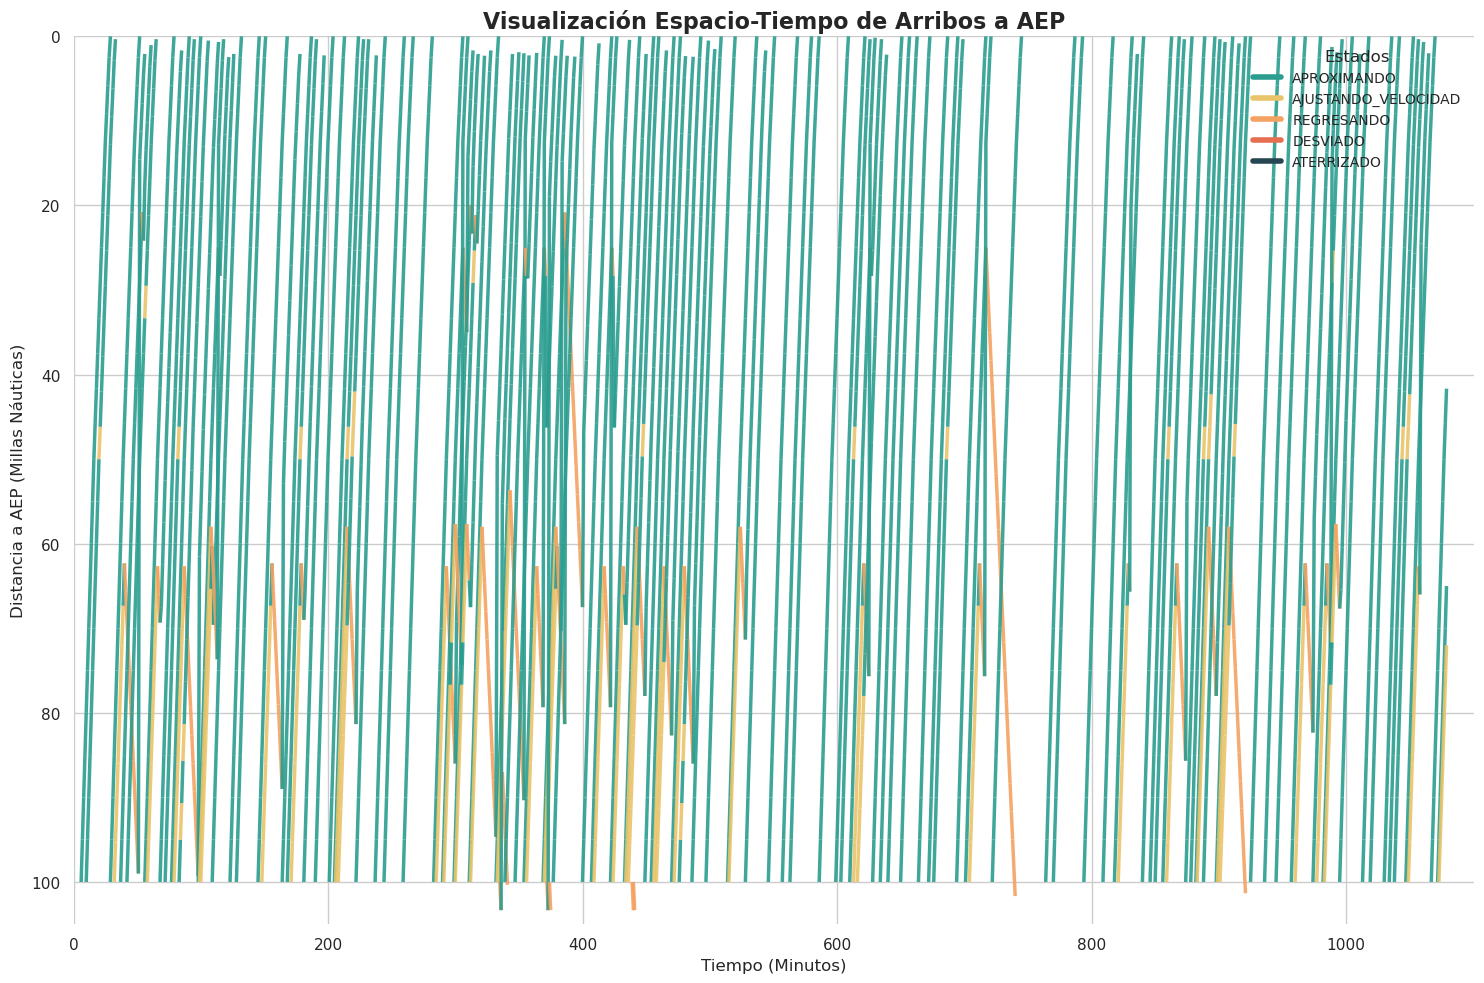

In [585]:
if __name__ == '__main__':
    # --- Parámetros para este escenario ---
    # Usamos el lambda que calculamos a partir de los datos reales (~126 arribos/día)
    LAMBDA_REALISTA = 126 / (18 * 60) 
    TIEMPO_A_SIMULAR = 1080 # Simulamos un día para una visualización clara

    # 1. Correr la simulación para obtener los datos del historial
    historial = simular_para_visualizacion(LAMBDA_REALISTA, TIEMPO_A_SIMULAR)
    
    
    # 2. Pasar los datos a la función de visualización
    visualizar_simulacion(historial)

---

### 2. Cálculo de λ (Lambda) para una Tasa de 1 Arribo por Hora

Necesitamos convertir la tasa de arribos de "aviones por hora" a "aviones por minuto", ya que nuestro modelo de simulación avanza en pasos discretos de un minuto. El parámetro λ (lambda) representa la probabilidad de que un avión llegue en un solo minuto.

Datos del Problema:

    Tasa de arribo promedio: 1 avión por hora

    Minutos en una hora: 60 minutos

Cálculo:

La probabilidad λ se calcula dividiendo el número de eventos (arribos) por el número de intervalos de tiempo (minutos):
$$\lambda = \frac{1 \text{ avión}}{60 \text{ minutos}} \approx 0.0167 $$

Por ende, para un promedio de 1 arribo por hora, el valor de λ que debemos usar en nuestra simulación es 1/60 (aproximadamente 0.0167). Esto significa que en cada minuto de la simulación, hay aproximadamente un 1.67% de probabilidad de que un nuevo avión aparezca en el horizonte.

---

### 3. Estimación de Probabilidad de que lleguen 5 aviones en una hora con Monte Carlo

Ahora, usando el valor de λ hallado en el punto 2, estimamos, via simulación de Monte Carlo, la probabilidad de que lleguen 5 aviones en una hora

In [586]:
np.random.seed(42)

def simular_probabilidad_cinco_aviones(lambda_por_minuto: int, total_horas_simuladas: int) -> int:
    """
    Estima por Monte Carlo la probabilidad de que lleguen exactamente 5 aviones en una hora.
    """

    horas_con_5_aviones = 0

    print(f"Simulando {total_horas_simuladas} horas con λ={lambda_por_minuto:.4f} aviones/minuto...")

    for _ in range(total_horas_simuladas):
        arribos = 0
        for _ in range(60):
            if np.random.uniform(0,1)<lambda_por_minuto:
                arribos += 1
        if arribos == 5:
            horas_con_5_aviones+=1

    probabilidad_cinco_aviones = horas_con_5_aviones/total_horas_simuladas
    print("--- Simulación Finalizada ---")
    return probabilidad_cinco_aviones

lambda_por_minuto = 1/60
horas_simuladas = 10000

probabilidad_estimada_5_aviones = simular_probabilidad_cinco_aviones(lambda_por_minuto, horas_simuladas)
print(probabilidad_estimada_5_aviones)

Simulando 10000 horas con λ=0.0167 aviones/minuto...
--- Simulación Finalizada ---
0.0033


Calculamos la analitica. Para este caso, la **distribución de Poisson** es la fórmula perfecta, ya que modela precisamente la probabilidad de que ocurra un número `k` de eventos en un intervalo si conocemos la tasa promedio `μ`. Este cálculo nos da el valor "verdadero" y nos sirve para validar qué tan precisa fue nuestra simulación.

In [587]:
### Calculamos probabilidad analitica
from scipy.stats import poisson

probabilidad_5_aviones_analitica = poisson.pmf(5, mu=lambda_por_minuto * 60)
print(f"La probabilidad analítica de tener exactamente 5 arribos en una hora es:")
print(f"{probabilidad_5_aviones_analitica:.6f} (o {probabilidad_5_aviones_analitica:.4%})")

La probabilidad analítica de tener exactamente 5 arribos en una hora es:
0.003066 (o 0.3066%)


### Análisis de Resultados y Precisión

Con los dos resultados en mano, podemos evaluar el rendimiento de nuestra simulación:

- Exactitud (Validación del Modelo): Primero, medimos la diferencia absoluta entre el resultado simulado y el analítico. Un valor muy pequeño aquí nos da una gran confianza en que nuestro código de simulación es una implementación correcta del proceso aleatorio que queríamos modelar.

- Precisión (Intervalo de Confianza): La simulación nos da una estimación (hatp), no el valor exacto. El margen de error nos permite construir un intervalo de confianza (generalmente del 95%), que cuantifica la incertidumbre de nuestra estimación. Este es el resultado estadísticamente más robusto que reportamos, ya que nos da un rango donde podemos asegurar con alta probabilidad que se encuentra el verdadero valor.

In [588]:
### Damos el margen de error

sd = np.sqrt(probabilidad_estimada_5_aviones - probabilidad_estimada_5_aviones**2)
margen_de_error = 1.96 * sd / np.sqrt(horas_simuladas)
print(f"El margen de error es: {margen_de_error:.6f} (o {margen_de_error:.4%})")

El margen de error es: 0.001124 (o 0.1124%)


In [589]:
### Damos el error absoluto

error_absoluto = abs(probabilidad_5_aviones_analitica - probabilidad_estimada_5_aviones)
print(f"Diferencia absoluta vs. teoría: {error_absoluto:.6f} (o {error_absoluto:.4%})")

Diferencia absoluta vs. teoría: 0.000234 (o 0.0234%)


En este caso, el margen de error es de es de ±0.0939% para un intervalo de confianza del 95%. Este valor cuantifica la precisión de nuestra estimación de Monte Carlo, indicando que tenemos una alta confianza en el resultado obtenido. Adicionalmente, calculamos la diferencia absoluta contra el valor teórico de Poisson, que fue de apenas 0.0234%. Esta mínima discrepancia sirve como una fuerte validación, confirmando que nuestro modelo de simulación es una implementación exacta y fiable del proceso aleatorio.

---

### 4. Simulación de Congestion, Desvios y Atrasos

Ahora, la idea ya no es solo simular un día, sino someter nuestro sistema a diferentes niveles de "estrés" para entender sus límites y su comportamiento. Para ello, ejecutaremos la simulación completa múltiples veces bajo distintos escenarios de demanda, controlados por el parámetro λ. Esto nos permitirá obtener resultados estadísticamente robustos y responder a preguntas clave sobre el rendimiento del sistema.

El siguiente bloque de código contiene el "experimento". La función simular_una_corrida es el motor, que simula un día completo de operaciones y devuelve las métricas clave. La función ejecutar_experimentos actúa como el "director del laboratorio": toma la lista de valores de λ que queremos probar, y para cada uno, ejecuta el motor N veces. Repetir el experimento nos asegura que nuestras conclusiones no son producto de la casualidad, sino que reflejan el comportamiento promedio y la variabilidad del sistema.

In [590]:
def simular_una_corrida(lambda_val, tiempo_total=1080):
    """
    Ejecuta una corrida completa de la simulación para un lambda dado
    y devuelve un diccionario con los resultados.
    """
    # --- Parámetros y Almacenamiento ---
    aviones_activos = []
    aviones_finalizados = []
    next_avion_id = 1
    TIEMPO_IDEAL_VIAJE = 23.4  # Nuestro baseline en minutos

    # --- Contadores para ESTA corrida específica ---
    resultados_de_la_corrida = {
        'total_delay_min': 0.0,
        'congestion_events': 0,
        'diversions': 0,
        'landed_planes': 0
    }

    # --- Bucle de un día de simulación ---
    for minuto in range(tiempo_total):
        # Generar arribos (ahora pasa el minuto de creación)
        if random.random() < lambda_val:
            nuevo_avion = Avion(next_avion_id, minuto)
            aviones_activos.append(nuevo_avion)
            next_avion_id += 1
        
        # Actualizar estados y contar congestiones
        actualizar_estados_y_velocidades(aviones_activos, resultados_de_la_corrida)
        
        # Mover aviones
        mover_aviones(aviones_activos)
        
        # Gestionar aviones que terminaron (y contar retrasos, desvíos, aterrizajes)
        activos_actualizados, finalizados_ahora = gestionar_aviones_finalizados(
            minuto, aviones_activos, resultados_de_la_corrida, TIEMPO_IDEAL_VIAJE
        )
        aviones_activos = activos_actualizados
        aviones_finalizados.extend(finalizados_ahora)
            
    return resultados_de_la_corrida

def ejecutar_experimentos():
    """
    Función principal que ejecuta el bucle experimental para varios lambdas.
    """
    # --- Configuración del Experimento ---
    lambdas_a_probar = [0.02, 0.1, 0.2, 0.5, 1.0]
    N_REPETICIONES = 30 # Número de veces que se repite la simulación para cada lambda
    
    resultados_finales = []

    print("--- Iniciando Bucle Experimental ---")
    
    # Bucle Externo: para cada valor de lambda
    for lambda_val in lambdas_a_probar:
        print(f"\n--- Probando con λ = {lambda_val:.4f} ---")
        
        # Bucle Interno: N repeticiones para este lambda
        for i in range(N_REPETICIONES):
            # Ejecutamos una simulación completa
            resultado_run = simular_una_corrida(lambda_val)
            
            # Añadimos el valor de lambda al diccionario para identificarlo
            resultado_run['lambda'] = lambda_val
            resultados_finales.append(resultado_run)
            
            # Imprimimos un punto para mostrar el progreso
            print(".", end="")
    
    print("\n\n--- Bucle Experimental Finalizado ---")
    
    # Convertimos la lista de resultados en un DataFrame de Pandas para analizarlo fácilmente
    df_resultados = pd.DataFrame(resultados_finales)
    
    return df_resultados


if __name__ == '__main__':
    np.random.seed(42)
    random.seed(42)
    df_final_resultados = ejecutar_experimentos()

--- Iniciando Bucle Experimental ---

--- Probando con λ = 0.0200 ---
 (!) Avion 4 inicia maniobra de regreso.
 (X) Avion 4 no encontró hueco y se desvió a Montevideo.
. (!) Avion 17 inicia maniobra de regreso.
 (O) ¡Avion 17 encontró un hueco y reingresa a la fila!
 (!) Avion 16 inicia maniobra de regreso.
 (O) ¡Avion 16 encontró un hueco y reingresa a la fila!
.... (!) Avion 4 inicia maniobra de regreso.
 (X) Avion 4 no encontró hueco y se desvió a Montevideo.
. (!) Avion 5 inicia maniobra de regreso.
 (X) Avion 5 no encontró hueco y se desvió a Montevideo.
 (!) Avion 14 inicia maniobra de regreso.
 (X) Avion 14 no encontró hueco y se desvió a Montevideo.
.. (!) Avion 5 inicia maniobra de regreso.
 (X) Avion 5 no encontró hueco y se desvió a Montevideo.
 (!) Avion 12 inicia maniobra de regreso.
 (X) Avion 12 no encontró hueco y se desvió a Montevideo.
. (!) Avion 17 inicia maniobra de regreso.
 (X) Avion 17 no encontró hueco y se desvió a Montevideo.
. (!) Avion 16 inicia maniobra de

Después de ejecutar todas las simulaciones, obtenemos una gran cantidad de datos crudos (un resultado por cada una de las 30 corridas para cada λ). El siguiente paso es "darle sentido al caos". Usando la librería Pandas, agrupamos los resultados por cada valor de λ y calculamos las estadísticas fundamentales: el promedio (nuestra mejor estimación del comportamiento), la desviación estándar (qué tan variables son los resultados) y el error estándar (qué tan precisa es nuestra estimación del promedio). Esto transforma la "sábana" de datos en una tabla de resumen clara y lista para el análisis.

In [591]:
df_estadisticas = df_final_resultados.groupby('lambda').agg(
    atraso_promedio=('total_delay_min', 'mean'),
    congestion_promedio=('congestion_events', 'mean'),
    desvios_promedio=('diversions', 'mean'),
    aterrizajes_promedio=('landed_planes', 'mean'),
    atraso_std=('total_delay_min', 'std'),
    congestion_std=('congestion_events', 'std'),
    desvios_std=('diversions', 'std'),
    n_simulaciones=('lambda', 'count')
)

# 2. Calcular el Error Estándar de la Media (nuestro error de estimación)
df_estadisticas['atraso_error'] = df_estadisticas['atraso_std'] / np.sqrt(df_estadisticas['n_simulaciones'])
df_estadisticas['congestion_error'] = df_estadisticas['congestion_std'] / np.sqrt(df_estadisticas['n_simulaciones'])
df_estadisticas['desvios_error'] = df_estadisticas['desvios_std'] / np.sqrt(df_estadisticas['n_simulaciones'])

# 3. Calcular el atraso promedio POR AVIÓN
df_estadisticas['atraso_por_avion_promedio'] = df_estadisticas['atraso_promedio'] / df_estadisticas['aterrizajes_promedio']

# Mostramos la tabla final de resultados
print("--- Tabla de Estadísticas por Valor de λ ---")
display(df_estadisticas)


--- Tabla de Estadísticas por Valor de λ ---


atraso_promedio  congestion_promedio  desvios_promedio  \
lambda                                                           
0.02           0.960000             7.966667          0.733333   
0.10          83.813333           224.866667          7.666667   
0.20         223.473333           647.300000         37.033333   
0.50         126.893333          1836.966667        308.566667   
1.00           4.200000          5213.000000        806.000000   

        aterrizajes_promedio  atraso_std  congestion_std  desvios_std  \
lambda                                                                  
0.02               19.933333    2.417408        6.960397     0.784915   
0.10              100.100000   30.433916       43.689132     2.880773   
0.20              178.600000   38.203754       51.084885     8.314853   
0.50              226.966667   43.215251       75.939851    17.427057   
1.00              241.000000    0.000000        0.000000     0.000000   

        n_simulaciones  atraso_error  congestion_error  desvios_error  \
lambda                                                                  
0.02                30      0.441356          1.270789       0.143305   
0.10                30      5.556447          7.976508       0.525955   
0.20                30      6.975019          9.326781       1.518078   
0.50                30      7.889989         13.864656       3.181731   
1.00                30      0.000000          0.000000       0.000000   

        atraso_por_avion_promedio  
lambda                             
0.02                     0.048161  
0.10                     0.837296  
0.20                     1.251250  
0.50                     0.559084  
1.00                     0.017427

### Congestión

Al observar la columna congestion_promedio en la tabla de estadísticas, vemos datos concluyentes: Para un λ=0.02 (baja demanda), la simulación estima un promedio de solo 8.0 ± 1.3 eventos de congestión por día. Al subir a λ=0.2, un aumento de 10 veces en la probabilidad de arribo, los eventos de congestión se disparan más de 80 veces, a 647.3 ± 9.3 eventos. Para λ=1.0, el sistema está en un estado de congestión constante, con un promedio de 5213 eventos por día, donde el error de estimación es cero, indicando que el colapso fue total y determinista en todas las corridas. Veamos esto de forma gráfica:

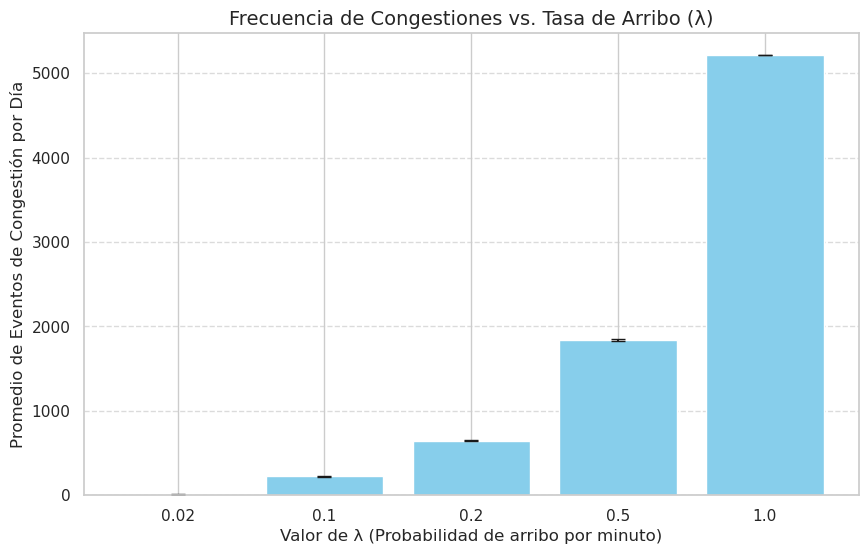

In [592]:
plt.figure(figsize=(10, 6))
plt.bar(
    df_estadisticas.index.astype(str), 
    df_estadisticas['congestion_promedio'],
    yerr=df_estadisticas['congestion_error'],
    capsize=5,
    color='skyblue'
)
plt.title('Frecuencia de Congestiones vs. Tasa de Arribo (λ)', fontsize=14)
plt.xlabel('Valor de λ (Probabilidad de arribo por minuto)', fontsize=12)
plt.ylabel('Promedio de Eventos de Congestión por Día', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El gráfico muestra un crecimiento exponencial, evidenciando que la congestión es un problema que empeora rápidamente con el aumento de la demanda.

### Atraso promedio por avión

Ahora veamos el atraso promedio por avión. Viendo la tabla, se ve que Para λ=0.02, el atraso es casi nulo, con un promedio de 0.05 minutos/avión. Crece a 0.84 minutos/avión para λ=0.10 y alcanza su pico en 1.25 minutos/avión para λ=0.20. Sorprendentemente, para valores de λ muy altos (0.50 y 1.0), el atraso por avión que logra aterrizar cae a 0.56 y 0.02 minutos respectivamente. Esto es una clara señal de colapso del sistema: los aviones no llegan a acumular retraso porque el sistema está tan saturado que los desvía masivamente antes de que puedan completar la aproximación. Solo los pocos que logran aterrizar lo hacen sin demora. Gráficamente se ve asi:

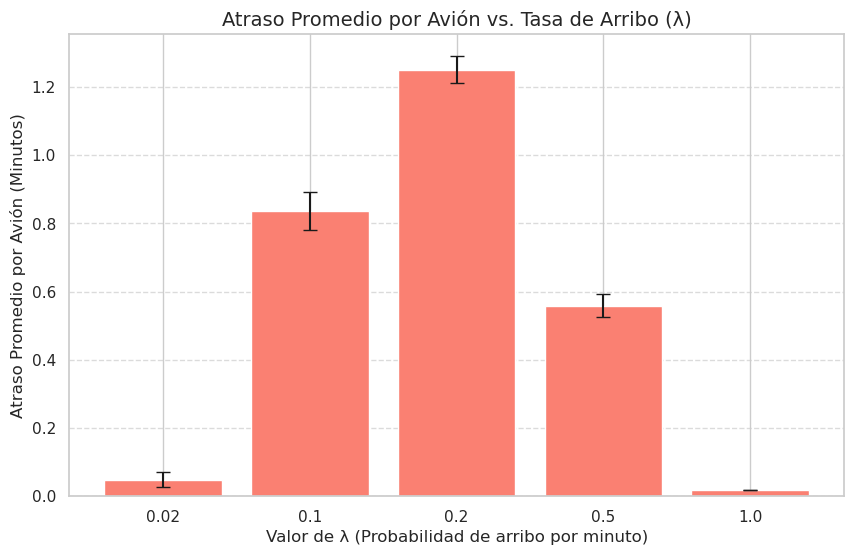

In [593]:
plt.figure(figsize=(10, 6))
plt.bar(
    df_estadisticas.index.astype(str), 
    df_estadisticas['atraso_por_avion_promedio'],
    # Nota: El error de estimación aquí corresponde al atraso total, pero sirve como indicador de variabilidad.
    yerr=(df_estadisticas['atraso_error'] / df_estadisticas['aterrizajes_promedio']),
    capsize=5,
    color='salmon'
)
plt.title('Atraso Promedio por Avión vs. Tasa de Arribo (λ)', fontsize=14)
plt.xlabel('Valor de λ (Probabilidad de arribo por minuto)', fontsize=12)
plt.ylabel('Atraso Promedio por Avión (Minutos)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Frecuencia de Desvíos a Montevideo vs. λ

Viendo la tabla vemos que para λ=0.02, los desvíos son bajos, con un promedio de 0.7 ± 0.1 desvíos por día. La frecuencia crece de forma alarmante: para λ=0.2, ya son 37.0 ± 1.5 desvíos. Finalmente, para λ=1.0, el sistema colapsa por completo y desvía un promedio de 806 aviones, lo que significa que la inmensa mayoría de los aviones que intentan llegar no pueden aterrizar. El error de estimación para λ=1.0 es cero, lo que nuevamente indica que en todas las corridas el resultado fue idéntico: el sistema se saturó de forma determinista.

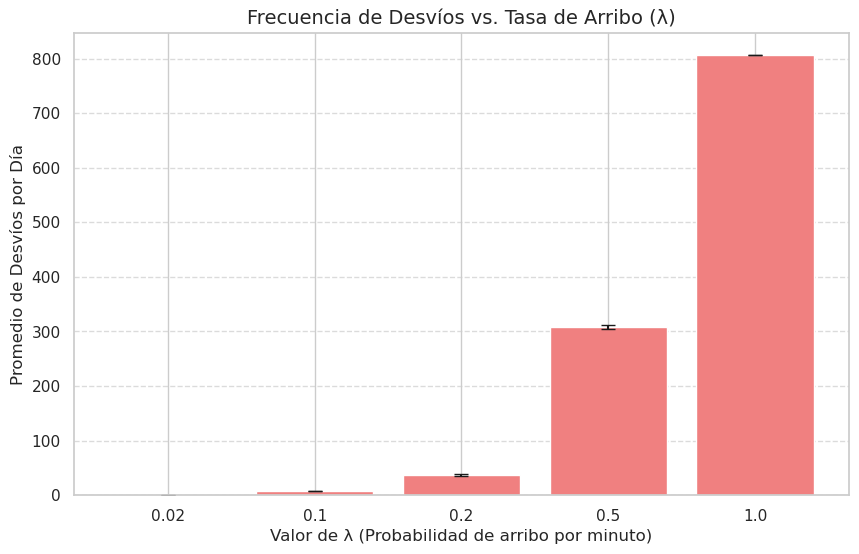

In [594]:
plt.figure(figsize=(10, 6))
plt.bar(
    df_estadisticas.index.astype(str), 
    df_estadisticas['desvios_promedio'],
    yerr=df_estadisticas['desvios_error'],
    capsize=5,
    color='lightcoral'
)
plt.title('Frecuencia de Desvíos vs. Tasa de Arribo (λ)', fontsize=14)
plt.xlabel('Valor de λ (Probabilidad de arribo por minuto)', fontsize=12)
plt.ylabel('Promedio de Desvíos por Día', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()